<a href="https://colab.research.google.com/github/Anish478/GANs/blob/main/gan_imple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch: 0 	 Discriminator Loss: 0.6525554656982422 Generator Loss: 0.7441568970680237
Epoch: 1 	 Discriminator Loss: 0.5198396444320679 Generator Loss: 1.018709659576416
Epoch: 2 	 Discriminator Loss: 0.5894029140472412 Generator Loss: 1.0107914209365845
Epoch: 3 	 Discriminator Loss: 0.4245982766151428 Generator Loss: 1.2021517753601074
Epoch: 4 	 Discriminator Loss: 0.3938138484954834 Generator Loss: 1.2511235475540161
Epoch: 5 	 Discriminator Loss: 0.5314590930938721 Generator Loss: 1.0511879920959473
Epoch: 6 	 Discriminator Loss: 0.5138043761253357 Generator Loss: 1.24779212474823
Epoch: 7 	 Discriminator Loss: 0.3085830807685852 Generator Loss: 1.4627248048782349
Epoch: 8 	 Discriminator Loss: 0.38731324672698975 Generator Loss: 1.410362720489502
Epoch: 9 	 Discriminator Loss: 0.571742594242096 Generator Loss: 1.0699706077575684
Epoch: 10 	 Discriminator Loss: 0.5239443182945251 Generator Loss: 1.1646835803985596
Epoch: 11 	 Discriminator Loss: 0.7227908372879028 Generator Loss: 1

(-0.5, 241.5, 121.5, -0.5)

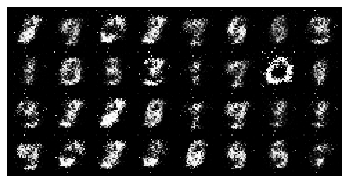

In [ ]:
#importing essential libraries
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils import data
import torchvision

import matplotlib.pyplot as plt
import numpy as np

#setting up the hyperparameters
learning_rate = 2e-4
noise_dim = 32
image_dim = 28 * 28 * 1
batch_size = 32
num_epochs = 100


class Generator(nn.Module):
    def __init__(self, noise_dim, image_dim):
        super(Generator,self).__init__()
        self.linear1 = nn.Linear(noise_dim, 128)
        self.relu = nn.LeakyReLU(0.01)
        self.linear2 = nn.Linear(128, image_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.tanh(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, in_image):
        super(Discriminator,self).__init__()
        self.linear1 = nn.Linear(in_image, 64)
        self.relu = nn.LeakyReLU(0.01)
        self.linear2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

discriminator = Discriminator(image_dim)
generator = Generator(noise_dim, image_dim)
noise = torch.randn((batch_size, noise_dim))


tf = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.5,), (0.5,)),]
)
ds = torchvision.datasets.MNIST(root="dataset/", transform=tf, download=True)
loader = data.DataLoader(ds, batch_size=batch_size, shuffle=True)


#Visualizing real data
real_sample = iter(loader).next()[0]
img_grid_real = torchvision.utils.make_grid(real_sample, normalize=True)
npgrid = img_grid_real.cpu().numpy()
plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
plt.axis('off')


#setting up the optimizers
opt_discriminator = optim.Adam(discriminator.parameters(), lr=learning_rate)
opt_generator = optim.Adam(generator.parameters(), lr=learning_rate)
criterion = nn.BCELoss()


for epoch in range(num_epochs):
    for id, (training_sample, _) in enumerate(loader):
        training_sample = training_sample.view(-1, 784)
        batch_size = training_sample.shape[0]

        ### Training the Discriminator
        noise = torch.randn(batch_size, noise_dim)
        fake_sample = generator(noise)
        disc_realSample = discriminator(training_sample).view(-1)
        lossD_realSample = criterion(disc_realSample, torch.ones_like(disc_realSample))
        disc_fakeSample = discriminator(fake_sample).view(-1)
        lossD_fakeSample = criterion(disc_fakeSample, torch.zeros_like(disc_fakeSample))
        lossD = (lossD_realSample + lossD_fakeSample) / 2
        discriminator.zero_grad()
        #we are trying to minimize the total classification error
        lossD.backward(retain_graph=True)
        opt_discriminator.step()

        ### Training the Generator
        lossD_fakeSample = discriminator(fake_sample).view(-1)
        lossG = criterion(lossD_fakeSample, torch.ones_like(lossD_fakeSample))#we are trying to maximize the error of classification of fake image by the discriminator
        generator.zero_grad()
        lossG.backward()
        opt_generator.step()

        if id == 0:
            print( "Epoch: {epoch} \t Discriminator Loss: {lossD} Generator Loss: {lossG}".format( epoch=epoch, lossD=lossD, lossG=lossG))

fake = generator(noise).reshape(-1, 1, 28, 28)
img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
npgrid = img_grid_fake.cpu().numpy()
plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
plt.axis('off')